# BERT Fine-Tuning Sentence Classification
Copyright 2023 Denis Rothman

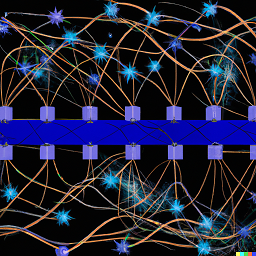
image copyright 2023, Denis Rothman & DALL-E 2

**The headings of the cells and the table of contents were modified to refer to the titles of the sections in the book.** The descriptions of the cells have been rewritten for educational purposes. Some additional information was added.

This notebook shows how to fine-tune a transformer model. Many pretrained and fine-tuned transformer models are available online. Some models, such as OpenAI LLMs, do not need to be fine-tuned for many tasks.

It is highly recommended to understand this notebook to grasp the architecture of transformer models.

Contributer: George Mihaila

[Reference Notebook by Chris McCormick and Nick Ryan](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX)

[Reference Article by Chris McCormick and Nick Ryan](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

# Installing Hugging Face Transformers

In [27]:
try:
  import transformers
except:
  print("Installing transformers")
  !pip -q install transformers

#Importing the modules

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange  #for progress bars
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image #for image rendering

#Specifying CUDA as the device for torch

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Sun Jun 18 11:03:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    42W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Loading the CoLA dataset


**Corpus of Linguistic Accepability(CoLA)**

"...English sentences labeled as grammatical or ungrammatical from published linguistics literature..."

[Warstadt, A., Singh, A., & Bowman, S. R. (2018). Neural Network Acceptability Judgments.](https://arxiv.org/abs/1805.12471)

[Source of the datasets](https://nyu-mll.github.io/CoLA/)

In [30]:
#Development access to delete when going into production
from google.colab import drive
drive.mount('/content/drive')

with open('drive/MyDrive/files/github.txt', 'r') as f:
    github_token = f.read().strip()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
#Development access to delete when going into production
with open('drive/MyDrive/files/github.txt', 'r') as f:
    github_token = f.read().strip()

In [32]:
#Remove this cell when GitHub repository made public
#This cell will be deleted when the repository is made public
import requests
from PIL import Image
from io import BytesIO

def get_image_from_github(image_name,github_token):
    # Headers for the request
    headers = {'Authorization': f'token {github_token}'}

    # The base URL of the image files in the GitHub repository
    base_url = 'https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/main/Notebook%20images/05/'

    # Make the request
    response = requests.get(base_url + image_name, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Read the image
        image = Image.open(BytesIO(response.content))

        # Return the image
        return image
    else:
        print(f'Error {response.status_code}: Could not access the image file.')
        return None

In [33]:
#production access when GitHub repo name is final and the repo goes public
'''
import os
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/in_domain_train.tsv --output "in_domain_train.tsv"
'''

'\nimport os\n!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/in_domain_train.tsv --output "in_domain_train.tsv"\n'

In [34]:
#Development access to delete when going into production
!curl -H 'Authorization: token {github_token}' -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/in_domain_train.tsv --output "in_domain_train.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  1249k      0 --:--:-- --:--:-- --:--:-- 1245k


In [35]:
#production access when GitHub repo name is final and the repo goes public
#!curl -L https://raw.githubusercontent.com/Denis2054/Transformers_3rd_Edition/master/Chapter05/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

In [36]:
##Development access to delete when going into production
!curl -H 'Authorization: token {github_token}' -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0  1113k      0 --:--:-- --:--:-- --:--:-- 1113k


In [37]:
#Change URL when repo goes public and delete this comment
#Image('https://github.com/Denis2054/Transformers-for-NLP-2nd-Edition/raw/main/Notebook%20images/05/B17948_05_05.png', width=600) #This is used for rendering images in the notebook

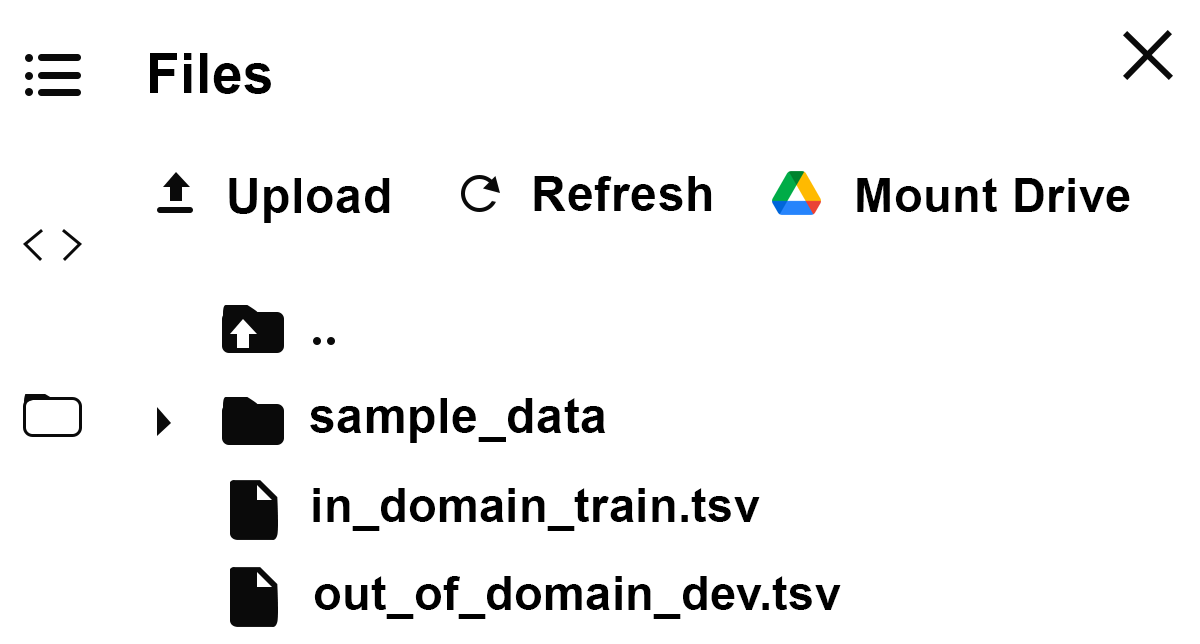

In [38]:
# Delete this cell when repository goes public and uncomment the preceding cell
display(get_image_from_github('B17948_05_05.png',github_token) or print('Image not found'))

In [39]:
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [40]:
df.sample(10)

,sentence_source,label,label_notes,sentence
436,bc01,1,NaN,mickey looked up the reference .
5857,c_13,1,NaN,the brazilians pumped the oil across the river .
1554,r-67,1,NaN,"tom ordered bacon , and dick lettuce , and har..."
5921,c_13,1,NaN,michael asked a question .
6493,d_98,1,NaN,is it possible for everyone to to pledge $ 1000 ?
6106,c_13,1,NaN,the audience laughed .
1980,r-67,0,??,the man who i gave john this picture of was ba...
8454,ad03,1,NaN,jason asked whether the potion was ready
7519,sks13,1,NaN,the boys fought with each other .
6303,c_13,1,NaN,calvin will strike himself and otto will strik...


#Creating sentences, label lists, and adding BERT tokens

In [41]:
sentences = df.sentence.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

#Activating the BERT tokenizer

**Note**: If the download fails, try again. Occasionally, the download function may timeout for several reasons, including server load.

You can also manually download 'bert-based-uncased' from the Hugging Face website: https://huggingface.co/bert-base-uncased

In [42]:
from transformers import BertTokenizer
try:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    print("Tokenizer downloaded successfully.")
except Exception as e:
    print("An error occurred while downloading the tokenizer.")
    print(str(e))
    import traceback
    print(traceback.format_exc())

Tokenizer downloaded successfully.


In [43]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


#Processing the data

In [44]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

#Creating attention masks

In [45]:
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

#Splitting the data into training and validation sets

In [46]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

#Converting all the data into torch tensors

In [47]:
# Torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

#Selecting a batch size and creating an iterator

In [48]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


#BERT model configuration

In [49]:
# Initializing a BERT bert-base-uncased style configuration
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



#Loading the Hugging Face BERT uncased base model

In [50]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = nn.DataParallel(model)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

#Optimizer grouped parameters

In [51]:
#This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters.
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01.
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},

    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not
# the names.

In [52]:
# Displaying a sample of the parameter_optimizer:  layer 3
layer_parameters = [p for n, p in model.named_parameters() if 'layer.3' in n]

In [53]:
# Displaying names of parameters for which weight decay is not applied
no_decay

['bias', 'LayerNorm.weight']

In [54]:
# Displaying the list of the two dictionaries
small_sample = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.1},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.0}
]

for i, group in enumerate(small_sample):
    print(f"Group {i+1}:")
    print(f"Weight decay rate: {group['weight_decay_rate']}")
    for j, param in enumerate(group['params']):
        print(f"Parameter {j+1}: {param}")

Group 1:
Weight decay rate: 0.1
Parameter 1: Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       device='cuda:0', requires_grad=True)
Parameter 2: Parameter containing:
tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-03,
          4.3435e-04, -2.6949e-

#The hyperparameters for the training loop

In [55]:
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [56]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#The training loop

In [57]:
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5303759499456873


Epoch:  25%|██▌       | 1/4 [00:43<02:11, 43.76s/it]

Validation Accuracy: 0.7935956790123456
Train loss: 0.3262688801372694


Epoch:  50%|█████     | 2/4 [01:24<01:24, 42.07s/it]

Validation Accuracy: 0.8167438271604938
Train loss: 0.19375419928170587


Epoch:  75%|███████▌  | 3/4 [02:05<00:41, 41.50s/it]

Validation Accuracy: 0.8290895061728395
Train loss: 0.1241693497361051


Epoch: 100%|██████████| 4/4 [02:46<00:00, 41.57s/it]

Validation Accuracy: 0.8314043209876544


#Training evaluation

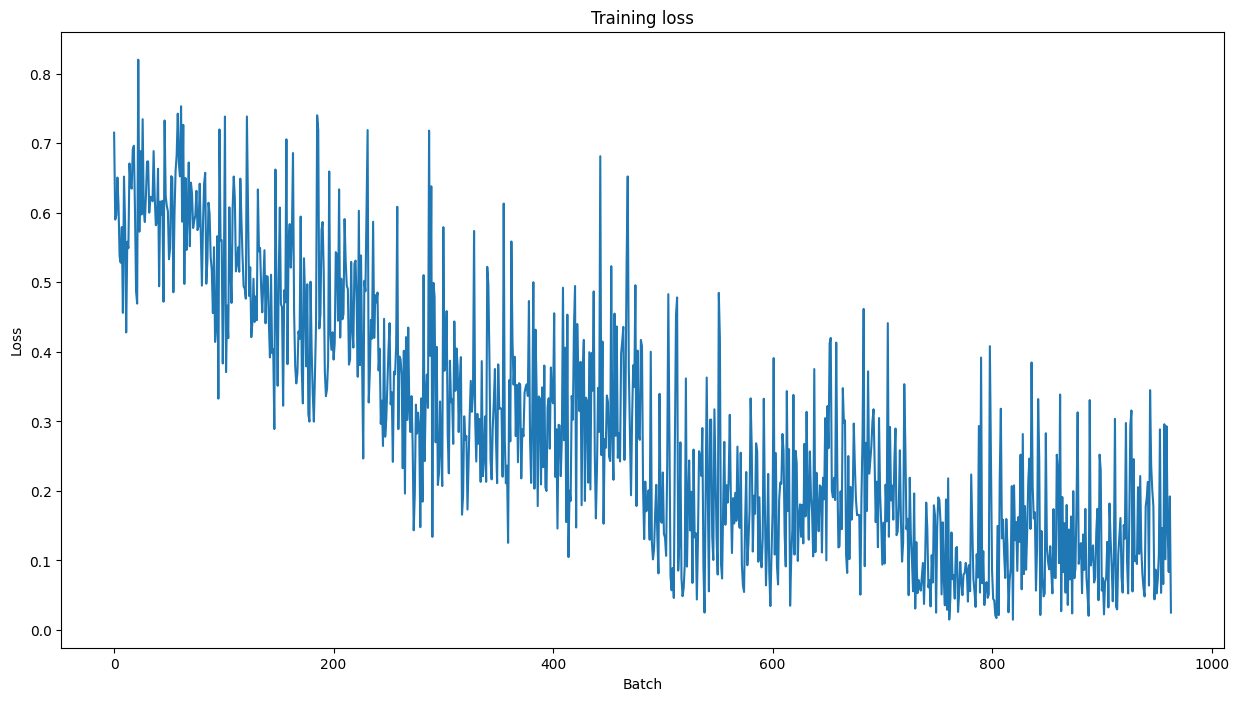

In [58]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

#Predicting and evaluating using the holdout dataset

In [59]:
#loading the holdout dataset
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [60]:
df.shape

(516, 4)

In [61]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [62]:
#Softmax logits
import numpy as np

def softmax(logits):
    e = np.exp(logits)
    return e / np.sum(e)

In [63]:
import torch
import numpy as np

# Put model in evaluation mode
model.eval()

# Tracking variables
raw_predictions, predicted_classes, true_labels = [], [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = outputs['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Convert input_ids back to words
  b_input_ids = b_input_ids.to('cpu').numpy()
  batch_sentences = [tokenizer.decode(input_ids, skip_special_tokens=True) for input_ids in b_input_ids]

  # Apply softmax function to convert logits into probabilities
  probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)

  # The predicted class is the one with the highest probability
  batch_predictions = np.argmax(probabilities, axis=1)

  # Print the sentences and the corresponding predictions for this batch
  for i, sentence in enumerate(batch_sentences):
    print(f"Sentence: {sentence}")
    print(f"Prediction: {logits[i]}")
    print(f"Sofmax probabilities", softmax(logits[i]))
    print(f"Prediction: {batch_predictions[i]}")
    print(f"True label: {label_ids[i]}")

  # Store raw predictions, predicted classes and true labels
  raw_predictions.append(logits)
  predicted_classes.append(batch_predictions)
  true_labels.append(label_ids)

Sentence: somebody just left - guess who.
Prediction: [-2.3857849  2.9543722]
Sofmax probabilities [0.00477223 0.9952278 ]
Prediction: 1
True label: 1
Sentence: they claimed they had settled on something, but it wasn't clear what they had settled on.
Prediction: [-2.1197686  2.271345 ]
Sofmax probabilities [0.01223537 0.98776466]
Prediction: 1
True label: 1
Sentence: if sam was going, sally would know where.
Prediction: [-2.1350448  2.4820292]
Sofmax probabilities [0.00978498 0.990215  ]
Prediction: 1
True label: 1
Sentence: they're going to serve the guests something, but it's unclear what.
Prediction: [-2.4500535  2.6898599]
Sofmax probabilities [0.00582408 0.9941759 ]
Prediction: 1
True label: 1
Sentence: she's reading. i can't imagine what.
Prediction: [-1.7348039  1.9691151]
Sofmax probabilities [0.02403492 0.975965  ]
Prediction: 1
True label: 1
Sentence: john said joan saw someone from her graduating class.
Prediction: [-2.5491738  3.2003586]
Sofmax probabilities [0.00317416 0.9

#Evaluating using the Matthews Correlation Coefficient

In [64]:
#Image('https://github.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/raw/main/Notebook%20images/03/B17948_05_005.png', width=800) #This is used for rendering images in the notebook

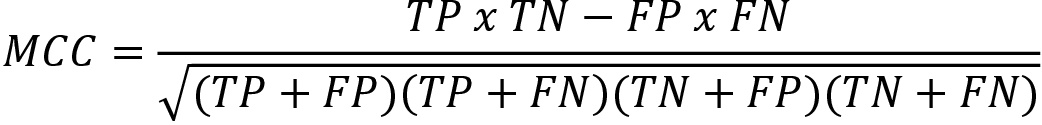

In [65]:
# Delete this cell when repository goes public and uncomment the preceding cell
display(get_image_from_github('B17948_05_005.png',github_token) or print('Image not found'))

In [66]:
from sklearn.metrics import matthews_corrcoef

# Initialize an empty list to store the Matthews correlation coefficient for each batch
matthews_set = []

# Iterate over each batch
for i in range(len(true_labels)):
  # Calculate the Matthews correlation coefficient for this batch

  # true_labels[i] are the true labels for this batch
  # predicted_classes[i] are the predicted classes for this batch
  # We don't need to use np.argmax because predicted_classes already contains the predicted classes

  matthews = matthews_corrcoef(true_labels[i], predicted_classes[i])

  # Add the result to our list
  matthews_set.append(matthews)

# Now matthews_set contains the Matthews correlation coefficient for each batch

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


# Matthews Correlation Coefficient evaluation for the whole dataset

In [67]:
from sklearn.metrics import matthews_corrcoef

# Flatten the true_labels and predicted_classes list of lists into single lists
true_labels_flattened = [label for batch in true_labels for label in batch]
predicted_classes_flattened = [pred for batch in predicted_classes for pred in batch]

# Calculate the MCC for the entire set of predictions
mcc = matthews_corrcoef(true_labels_flattened, predicted_classes_flattened)

print(f"MCC: {mcc}")

MCC: 0.5404323554886978
